In [1]:
import math
import os
import re
import string
from operator import itemgetter

import nltk
from bs4 import BeautifulSoup
from collections import defaultdict as dd
import pandas
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
path_to_help_sources = os.path.expanduser("~/Downloads/webHelpIJ2/")

print("Current directory:", os.getcwd())
print("Getting a list of HTML files from", path_to_help_sources + "...")

html_files = []

for file_name in os.listdir(path_to_help_sources)[:]:
    if ".html" in file_name:
        html_files.append(file_name)

print("There are", len(html_files), "HTML files")

Current directory: /Users/Alexey.Zhebel/IdeaProjects/CompLing/Project
Getting a list of HTML files from /Users/Alexey.Zhebel/Downloads/webHelpIJ2/...
There are 3244 HTML files


In [3]:
print("Getting sources from files that are topics (have <article>)...")

topic_sources = {}

for file_name in html_files:
    with open(path_to_help_sources + file_name, "r") as file:
        soup = BeautifulSoup(file.read(), "html.parser")

        article = soup.find("article")

        if article:
            topic_sources[file_name] = article

print("There are", len(topic_sources), "topics")

print(list(topic_sources.items())[2][1].prettify()[:200])

list(topic_sources.items())[2][0]

Getting sources from files that are topics (have <article>)...
There are 1505 topics
<article class="article" data-shortcut-switcher="inactive">
 <h1 data-availability-limit="Ultimate" data-toc="PHP_Built_In_Web_Server" id="PHP_Built_In_Web_Server.xml">
  Built-in web server
 </h1>
 <


'php-built-in-web-server.html'

In [4]:
print("Extracting text from topics (<h1-h6> and <p> tags in files that contain <article>)...")

topic_texts = {}

for item in topic_sources.items():
    topic_file_name = item[0]
    article = item[1]

    text = ""
    for tag in article.find_all(re.compile("^h[1-6]$|^p$")):
        text += tag.get_text() + "\n"

    topic_texts[topic_file_name] = text

print("There are", len(topic_texts), "topics")

print(list(topic_texts.items())[2][1][:200])

Extracting text from topics (<h1-h6> and <p> tags in files that contain <article>)...
There are 1505 topics
Built-in web server
The following is only valid when the PHP plugin is installed and enabled.
 IntelliJ IDEA has a built-in web server that can be used to preview and debug your application.  This ser


In [5]:
print("Saving plain text from topics to topic_text.csv...")

df = pandas.DataFrame.from_dict(topic_texts, orient="index")

print(df.shape)
df.to_csv("topic_text.csv")

Saving plain text from topics to topic_text.csv...
(1505, 1)


In [16]:
list(topic_texts.items())[0][1]

'Notifications\nUse this page to enable and disable notifications about certain events, change their presentation, and optionally enable their logging.\nItem\nDescription\nDisplay balloon notifications\nSelect this checkbox to enable event notifications for IntelliJ\xa0IDEA. (The notifications, generally, are shown in the balloons that appear on the screen when the corresponding events take place.)\nRegardless of the state of this option, you will always find all notifications from the current session in the Event log\nEnable system notifications\nSelect this checkbox to allow showing system notification.\nOn Windows, you may want to disable this option to hide IntelliJ\xa0IDEA icon from the system tray.\nGroup\nThis column lists groups of events that you may be notified of and/or that may be logged.\nPopup\nIf the Display balloon notification checkbox is selected, the settings in this column specify how the notifications for the corresponding group of events are shown.\nThe available 

In [17]:
s = "Notifications\nUse this page to enable and disable notifications about certain events, change their presentation, and optionally enable their logging.\nItem\nDescription\nDisplay balloon notifications\nSelect this checkbox to enable event notifications for IntelliJ\xa0IDEA."

s.replace("\xa0", "_")

tokenized = nltk.tokenize.word_tokenize(s.replace("\xa0", "_").lower())

clean = []

for word in tokenized:
    if word not in string.punctuation:
        clean.append(word.replace("_", " "))

print(tokenized)

print(clean)


['notifications', 'use', 'this', 'page', 'to', 'enable', 'and', 'disable', 'notifications', 'about', 'certain', 'events', ',', 'change', 'their', 'presentation', ',', 'and', 'optionally', 'enable', 'their', 'logging', '.', 'item', 'description', 'display', 'balloon', 'notifications', 'select', 'this', 'checkbox', 'to', 'enable', 'event', 'notifications', 'for', 'intellij_idea', '.']
['notifications', 'use', 'this', 'page', 'to', 'enable', 'and', 'disable', 'notifications', 'about', 'certain', 'events', 'change', 'their', 'presentation', 'and', 'optionally', 'enable', 'their', 'logging', 'item', 'description', 'display', 'balloon', 'notifications', 'select', 'this', 'checkbox', 'to', 'enable', 'event', 'notifications', 'for', 'intellij idea']


In [6]:
print("Tokenizing topics...")

topic_tokens = {}

for item in topic_texts.items():
    topic_file_name = item[0]
    topic_text = item[1].replace("\xa0", "_").replace("/", " ")

    tokens = nltk.tokenize.word_tokenize(topic_text.lower())

    stop_words = nltk.corpus.stopwords.words("english")
    clean_tokens = []

    for token in tokens:
        if token not in stop_words and token not in string.punctuation:
            clean_tokens.append(token.replace("_", " "))

    topic_tokens[topic_file_name] = clean_tokens

print("There are", len(topic_tokens), "topics")

print(list(topic_tokens.items())[2][1][:5])

Tokenizing topics...
There are 1505 topics
['built-in', 'web', 'server', 'following', 'valid']


In [7]:
print("Saving tokens from topics to topic_tokens.csv...")

df = pandas.DataFrame.from_dict(topic_tokens, orient="index")

df.to_csv("topic_tokens.csv")

Saving tokens from topics to topic_tokens.csv...


In [11]:
df.shape

(1505, 5691)

In [20]:
len(df.index)

1505

In [22]:
print("Creating a term frequency dataframe...")

term_freq_per_topic = {}

for item in topic_tokens.items():
    topic_file_name = item[0]
    tokens = item[1]

    num_of_tokens = len(tokens)

    term_freq = dd(int)

    for term in tokens:
        term_freq[term] += 1 / num_of_tokens

    term_freq_per_topic[topic_file_name] = term_freq

df = pandas.DataFrame.from_dict(term_freq_per_topic, orient="index").fillna(0)

print("There are", len(list(df.columns)), "terms in", len(list(df.index)), "topics")

df.to_csv("tf.csv")

print(df.iloc[:3, :3])
# print("--- --- ---")
# print(df["appdatajetbrainsproductversionbackup"][:10])

Creating a term frequency dataframe...
There are 13047 terms in 1505 topics
                             notifications       use      page
settings-notifications.html       0.071006  0.005917  0.005917
listeners.html                    0.020408  0.000000  0.000000
using-file-watchers.html          0.000631  0.012626  0.004419


In [25]:
df.columns[:5], df.index[:5]

(Index(['notifications', 'use', 'page', 'enable', 'disable'], dtype='object'),
 Index(['settings-notifications.html', 'listeners.html',
        'using-file-watchers.html', 'event-log-tool-window.html',
        'using-webpack.html'],
       dtype='object'))

In [ ]:
t = [col for col in df.columns if "appdata" in col]
print(t)

In [ ]:
with open(path_to_help_sources + "configuring-project-and-ide-settings.html", "r") as file:
    soup = BeautifulSoup(file.read(), "html.parser")

    article = soup.find("article")

    print(article.find("span", {"class":"filepath"}))

In [26]:
print("Counting tfidf per topic...")

df = pandas.read_csv("tf.csv", index_col=0)
total_docs = len(df)

print("There are", total_docs, "documents.")

print(df.iloc[:3, :3])

for term in df.columns:
    docs_with_term = 0
    for tf_in_doc in df[term].tolist():
        if tf_in_doc != 0:
            docs_with_term += 1

    idf = math.log10(total_docs / docs_with_term)

    df[term] = df[term].apply(lambda tf: tf * idf)

print(df.iloc[:3, :3])

df.to_csv("tfidf.csv")

Counting tfidf per topic...
There are 1505 documents.
                             notifications       use      page
settings-notifications.html       0.071006  0.005917  0.005917
listeners.html                    0.020408  0.000000  0.000000
using-file-watchers.html          0.000631  0.012626  0.004419
                             notifications       use      page
settings-notifications.html       0.148996  0.000771  0.002154
listeners.html                    0.042824  0.000000  0.000000
using-file-watchers.html          0.001325  0.001645  0.001608


In [27]:
df.shape

(1505, 13047)

backup			0.065250514715432
-backup			0.039068071720449
restore			0.0380489633544077
ide			0.0276707844539373
intellijideagetting-started-backup			0.026045381146966
product			0.022325516359577
settings			0.0209573325201728
2020.1			0.0203161188163429
.config			0.0203161188163429
2019.3			0.0196670922093952


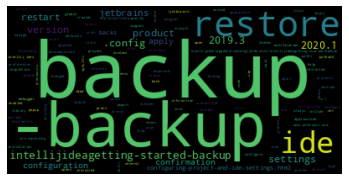

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


def show_wordcloud_by_freq_dict(freq_dict):
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=freq_dict)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

input_data = pandas.read_csv("tfidf.csv", index_col=0)

topic = "configuring-project-and-ide-settings.html"

sorted_frequency_table = sorted(dict(input_data.loc[topic]).items(), key=itemgetter(1), reverse=True)
for word, freq in sorted_frequency_table[:10]:
    print('\t\t\t'.join((word, str(freq))))

show_wordcloud_by_freq_dict(input_data.loc[topic].to_dict())

In [ ]:
texts = list(topic_texts.values())

# texts = ["Hello I am your friend", "Everybody needs a friend"]

vectorizer = TfidfVectorizer(stop_words=stop_words, use_idf=True, ngram_range=(1, 3))

vect = vectorizer.fit_transform(texts)

print(vect.shape)

In [ ]:
lsa = TruncatedSVD(n_components=10, n_iter=100)

lsa.fit(vect)

print(lsa.components_[0])

In [ ]:
terms = vectorizer.get_feature_names_out()

for i, comp in enumerate(lsa.components_):
    termsInComp = zip( terms,comp )
    sortedTerms = sorted(termsInComp, key=lambda x: x[1], reverse=True)[:10]
    print("Concept %d:" % i)
    for term in sortedTerms:
        print(term[0])
    print("---")

In [29]:
tfidf = pandas.read_csv("tfidf.csv", index_col=0)

query = input("What do you want to find?")

terms = query.split(" ")

print(terms)

for term in tfidf.columns:
    if term not in terms:
        tfidf.drop(term, axis=1, inplace=True)

print(tfidf.shape)
print(tfidf.head(5))

results = {}

for topic in tfidf.index:
    scores = tfidf.loc[topic].tolist()
    if all(v == 0 for v in scores):
        tfidf.drop(topic, axis=0, inplace=True)
    elif all(v != 0 for v in scores):
        final_score = 1
        for score in scores:
            final_score *= score
        results[topic] = final_score

print(tfidf.shape)
print(tfidf.head(5))

results = dict(sorted(results.items(), key = lambda x: x[1], reverse=True))

print(len(results))

for key, value in results.items():
    print(key, value)


['file', 'template']
(1505, 2)
                                 file  template
settings-notifications.html  0.000000   0.00000
listeners.html               0.000000   0.00000
using-file-watchers.html     0.013313   0.00149
event-log-tool-window.html   0.000000   0.00000
using-webpack.html           0.006839   0.00000
(998, 2)
                                                        file  template
using-file-watchers.html                            0.013313   0.00149
using-webpack.html                                  0.006839   0.00000
installing-and-removing-external-software-using...  0.002332   0.00000
managing-plugins.html                               0.001977   0.00000
big-data-tools-configuration.html                   0.001670   0.00000
212
save-file-as-template-dialog.html 0.0012489149688259384
settings-file-and-code-templates.html 0.0008012569784470213
using-file-and-code-templates.html 0.0005538316817161398
navigating-between-text-and-message-file.html 0.0005092957302222603
t